In [1]:
%matplotlib inline


Training an MNIST Classifier
=====
## Custom Dataset, Model Checkpointing, and Fine-tune

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os.path as osp
import numpy as np
from PIL import Image

## 1. Custom Dataset
PyTorch has many built-in datasets such as MNIST and CIFAR. In this tutorial, we demonstrate how to write your own dataset by implementing a custom MNIST dataset class. Use [this link](https://github.com/myleott/mnist_png/blob/master/mnist_png.tar.gz?raw=true) to download the mnist png dataset.

In [3]:
class MNIST(Dataset):
    """
    A customized data loader for MNIST.
    """
    def __init__(self,
                 root,
                 transform=None,
                 preload=False):
        """ Intialize the MNIST dataset
        
        Args:
            - root: root directory of the dataset
            - tranform: a custom tranform function
            - preload: if preload the dataset into memory
        """
        self.images = None
        self.labels = None
        self.filenames = []
        self.root = root
        self.transform = transform

        # read filenames
        for i in range(10):
            filenames = glob.glob(osp.join(root, str(i), '*.png'))
            for fn in filenames:
                self.filenames.append((fn, i)) # (filename, label) pair
                
        # if preload dataset into memory
        if preload:
            self._preload()
            
        self.len = len(self.filenames)
                              
    def _preload(self):
        """
        Preload dataset to memory
        """
        self.labels = []
        self.images = []
        for image_fn, label in self.filenames:            
            # load images
            image = Image.open(image_fn)
            # avoid too many opened files bug
            self.images.append(image.copy())
            image.close()
            self.labels.append(label)

    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        if self.images is not None:
            # If dataset is preloaded
            image = self.images[index]
            label = self.labels[index]
        else:
            # If on-demand data loading
            image_fn, label = self.filenames[index]
            image = Image.open(image_fn)
            
        # May use transform function to transform samples
        # e.g., random crop, whitening
        if self.transform is not None:
            image = self.transform(image)
        # return image and label
        return image, label

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [4]:
# Create the MNIST dataset. 
# transforms.ToTensor() automatically converts PIL images to
# torch tensors with range [0, 1]
trainset = MNIST(
    root='mnist_png/training',
    preload=True, transform=transforms.ToTensor(),
)
# Use the torch dataloader to iterate through the dataset
trainset_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)

# load the testset
testset = MNIST(
    root='mnist_png/testing',
    preload=True, transform=transforms.ToTensor(),
)
# Use the torch dataloader to iterate through the dataset
testset_loader = DataLoader(testset, batch_size=1000, shuffle=False, num_workers=0)

In [5]:
print(len(trainset))
print(len(testset))

60000
10000


### Visualize the dataset

tensor(8) tensor(0) tensor(2) tensor(5) tensor(4) tensor(6) tensor(1) tensor(1) tensor(4) tensor(7) tensor(0) tensor(2) tensor(5) tensor(5) tensor(7) tensor(5)


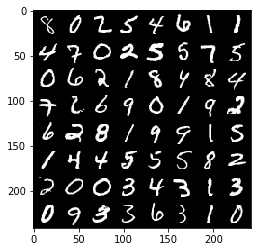

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainset_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(16)))

In [7]:
# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device('cuda' if use_cuda else "cpu")
print(device)

cuda


### Define a Conv Net


In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Train the network

In [9]:
def train(epoch, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            iteration += 1
        test()

In [10]:
def test():
    model.eval()  # set evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testset_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testset_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testset_loader.dataset),
        100. * correct / len(testset_loader.dataset)))

In [11]:
train(5)  # train 5 epochs should get you to about 97% accuracy

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.290484
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.313624
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.292382
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.282151
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.204112
Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.051165
Train Epoch: 0 [38400/60000 (64%)]	Loss: 1.911949
Train Epoch: 0 [44800/60000 (75%)]	Loss: 1.561916
Train Epoch: 0 [51200/60000 (85%)]	Loss: 1.544654
Train Epoch: 0 [57600/60000 (96%)]	Loss: 1.371464

Test set: Average loss: 0.7157, Accuracy: 8252/10000 (83%)

Train Epoch: 1 [3968/60000 (7%)]	Loss: 0.488220
Train Epoch: 1 [10368/60000 (17%)]	Loss: 0.304407
Train Epoch: 1 [16768/60000 (28%)]	Loss: 0.426961
Train Epoch: 1 [23168/60000 (39%)]	Loss: 0.699758
Train Epoch: 1 [29568/60000 (49%)]	Loss: 0.558383
Train Epoch: 1 [35968/60000 (60%)]	Loss: 0.428893
Train Epoch: 1 [42368/60000 (71%)]	Loss: 0.448840
Train Epoch: 1 [48768/60000 (81%)]	Loss: 0.370247
Train Epoch: 1 [55168/60000 (92%)]	Loss: 0.3670

## 2. Save the model (model checkpointing)

Now we have a model! Obviously we do not want to retrain the model everytime we want to use it. Plus if you are training a super big model, you probably want to save checkpoint periodically so that you can always fall back to the last checkpoint in case something bad happened or you simply want to test models at different training iterations.

Model checkpointing is fairly simple in PyTorch. First, we define a helper function that can save a model to the disk

In [12]:
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {'state_dict': model.state_dict(),
             'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [13]:
# create a brand new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
test()


Test set: Average loss: 2.3039, Accuracy: 1009/10000 (10%)



### Define a training loop with model checkpointing

In [14]:
def train_save(epoch, save_interval, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            if iteration % save_interval == 0 and iteration > 0:
                save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)
            iteration += 1
        test()
    
    # save the final model
    save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)

In [15]:
train_save(5, 500, 100)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.307490
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.312356
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.289403
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.283712
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.280137
Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.199229
model saved to mnist-500.pth
Train Epoch: 0 [38400/60000 (64%)]	Loss: 1.998729
Train Epoch: 0 [44800/60000 (75%)]	Loss: 1.690812
Train Epoch: 0 [51200/60000 (85%)]	Loss: 1.282540
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.993019

Test set: Average loss: 0.7469, Accuracy: 8209/10000 (82%)

Train Epoch: 1 [3968/60000 (7%)]	Loss: 0.413577
model saved to mnist-1000.pth
Train Epoch: 1 [10368/60000 (17%)]	Loss: 0.608578
Train Epoch: 1 [16768/60000 (28%)]	Loss: 0.595312
Train Epoch: 1 [23168/60000 (39%)]	Loss: 0.262869
Train Epoch: 1 [29568/60000 (49%)]	Loss: 0.282993
Train Epoch: 1 [35968/60000 (60%)]	Loss: 0.357782
model saved to mnist-1500.pth
Train Epoch: 1 [42368/60000 (71%)]	Loss: 0.292517
Train Ep

In [16]:
# create a new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# load from the final checkpoint
load_checkpoint('mnist-4690.pth', model, optimizer)
# should give you the final model accuracy
test()

model loaded from mnist-4690.pth

Test set: Average loss: 0.1081, Accuracy: 9653/10000 (97%)



## 3. Fine-tune a model

Sometimes you want to fine-tune a pretrained model instead of training a model from scratch. For example, if you want to train a model on a new dataset that contains natural images. To achieve the best performance, you can start with a model that's fully trained on ImageNet and fine-tune the model.

Finetuning a model in PyTorch is super easy! First, let's find out what we saved in a checkpoint

In [17]:
# What's in a state dict?
print(model.state_dict().keys())

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


### Finetune the fc layers

Now say we want to load the conv layers from the checkpoint and train the fc layers. We can simply load a subset of the state dict with the selected names

In [18]:
checkpoint = torch.load('mnist-4690.pth')
states_to_load = {}
for name, param in checkpoint['state_dict'].items():
    if name.startswith('conv'):
        states_to_load[name] = param

# Construct a new state dict in which the layers we want
# to import from the checkpoint is update with the parameters
# from the checkpoint
model_state = model.state_dict()
model_state.update(states_to_load)
        
model = Net().to(device)
model.load_state_dict(model_state)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [19]:
train(1)  # training 1 epoch will get you to 93%!

Train Epoch: 0 [0/60000 (0%)]	Loss: 3.163196
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.760190
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.715497
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.540484
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.565370
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.488912
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.524025
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.462761
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.247661
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.598823

Test set: Average loss: 0.1683, Accuracy: 9510/10000 (95%)



### Import pretrained weights in a different model

We can even use the pretrained conv layers in a different model.

In [20]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

model = SmallNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [21]:
checkpoint = torch.load('mnist-4690.pth')
states_to_load = {}
for name, param in checkpoint['state_dict'].items():
    if name.startswith('conv'):
        states_to_load[name] = param

# Construct a new state dict in which the layers we want
# to import from the checkpoint is update with the parameters
# from the checkpoint
model_state = model.state_dict()
model_state.update(states_to_load)
        
model.load_state_dict(model_state)

In [22]:
train(1)  # training 1 epoch will get you to 93%!

Train Epoch: 0 [0/60000 (0%)]	Loss: 5.420417
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.660528
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.549126
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.350035
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.298789
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.388864
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.340843
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.383705
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.435218
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.191111

Test set: Average loss: 0.1629, Accuracy: 9517/10000 (95%)

